In [71]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelEncoder
from scipy import stats
from sklearn.metrics import accuracy_score

import data_functions as fn
import model as md

In [72]:
# Read in the cleaned data from the previous notebook
team_data = pd.read_csv('BasketballData.csv').drop('Unnamed: 0', axis=1)
team_data = team_data[team_data.TeamID.notnull()]

In [73]:
team_data[team_data.Season==2009].head(3)

,Season,DayNum,TeamID,Win,Opp_TeamID,FG_rate,FT_rate,FG3_rate,ORB,DRB,...,Opp_FG_rate,Opp_FT_rate,Opp_FG3_rate,Opp_ORB,Opp_DRB,Opp_STL,Opp_BLK,Opp_AST,Opp_PF,Opp_Score_Diff
0,2009,7.0,1181.0,1.0,1342,0.439811,0.711419,0.345149,13.403704,24.340741,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
1,2009,8.0,1222.0,1.0,1342,0.410627,0.780318,0.350825,12.318182,23.901515,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
2,2009,25.0,1155.0,1.0,1342,0.453876,0.592604,0.352820,15.828502,22.785024,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05


### First I will look at the correlation between the features by constructing a heatmap

In [74]:
plot_data = team_data.drop(['DayNum','TeamID','Opp_TeamID','Win','Season'], axis=1)

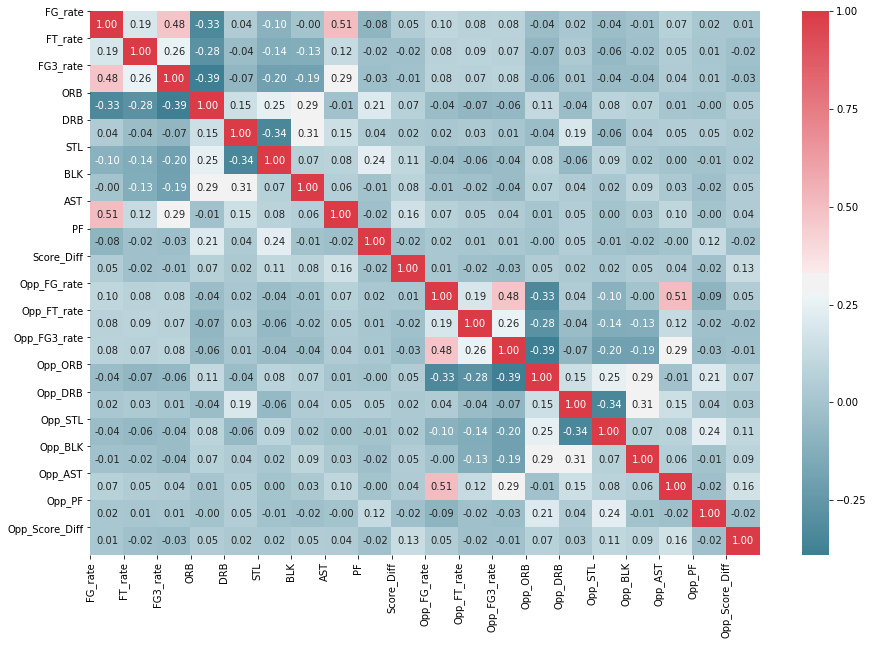

<Figure size 432x288 with 0 Axes>

In [75]:
fn.get_corr_heat_map(plot_data, False)
plt.savefig('CorrelationHeatMap_labeled.jpg')
plt.show()

### None of the features appear to be strongly correlated with each other. However, there appears to be a slight correlation between field goal rate and 3 point rate, and field goal rate and assists.

In [76]:
# Read in the tournament data
tour_data = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
tour_data = tour_data[tour_data.Season>2007]
tour_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1456,2008,134,1291,69,1164,60,N,0
1457,2008,136,1181,71,1125,70,N,0
1458,2008,136,1242,85,1340,61,N,0
1459,2008,136,1243,80,1425,67,N,0
1460,2008,136,1266,74,1246,66,N,0


In [77]:
# Fill null values with the column mean
data = team_data.apply(lambda x: x.fillna(x.mean()), axis=0)

In [78]:
# Create a column indicating whether the team was in the tournament the previous season
prev_trn = []

for i in data.index:
    year = data.Season[i]
    trn_df = tour_data[tour_data.Season==year-1]
    
    trn_list = [trn_df.WTeamID[k] for k in trn_df.index] + [trn_df.LTeamID[k] for k in trn_df.index]
    
    if data.TeamID[i] in trn_list:
        prev_trn.append(1)
    elif data.TeamID[i] not in trn_list:
        prev_trn.append(0)


data['Prev_Tourn'] = prev_trn

In [79]:
# Read in the team rankings data
rankings = pd.read_csv('TeamRankings.csv').drop('Unnamed: 0', axis=1)
rankings.head(3)

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,1,Villanova,5,1,5,9,51,71,23,17,14,47,19,6,13,50,59,50,75,72
1,2,Duke,9,12,2,6,4,12,2,1,6,5,11,2,3,1,6,1,1,2
2,3,Purdue,15,9,34,71,64,24,8,13,18,31,27,145,87,51,22,67,28,24


In [80]:
# Read in the file with the team names and IDs so that the correct IDs can be added to the rankings data
team_id_pairs = pd.read_csv('Team_id_pairs.csv').drop('Unnamed: 0', axis=1)

team_id_dict = {}

for i in team_id_pairs.index:
    name = team_id_pairs.TeamName[i]
    team_id = team_id_pairs.TeamID[i]
    team_id_dict[name] = team_id

In [81]:
# Create a column with the team IDs in the rankings data
t_id_list = []

for i in rankings.index:
    name = rankings.School[i]
    if name in team_id_dict:
        team_id = int(team_id_dict[name])
        t_id_list.append(team_id)
    elif name not in team_id_dict:
        t_id_list.append(0)
    
rankings['TeamID'] = t_id_list

rankings.head(3)

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,...,2008,2007,2006,2005,2004,2003,2002,2001,2000,TeamID
0,1,Villanova,5,1,5,9,51,71,23,17,...,47,19,6,13,50,59,50,75,72,1437
1,2,Duke,9,12,2,6,4,12,2,1,...,5,11,2,3,1,6,1,1,2,1181
2,3,Purdue,15,9,34,71,64,24,8,13,...,31,27,145,87,51,22,67,28,24,1345


In [82]:
# Create a column in the main dataframe with the previous year's ranking
prev_rank = []

for i in data.index:
    prev_year = str(data.Season[i]-1)
    team = data.TeamID[i]
    rank_year = list(rankings.TeamID)
    
    if team in rank_year:
        k = rankings[rankings.TeamID==team].index[0]
        rank = rankings[prev_year][k]
        prev_rank.append(int(rank))
    elif team not in rank_year:
        prev_rank.append(np.nan)
        
data['Prev_Rank'] = prev_rank

In [83]:
# Export the data to a csv file
data.to_csv('BasketBallData_2.csv')

### Now I will construct a few scatterplots to look at the correlation between some of the features

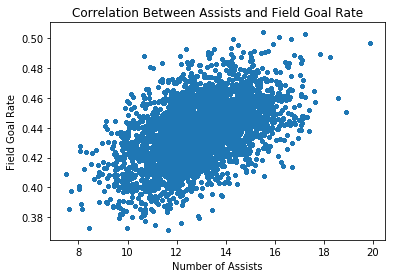

In [84]:
# Plot the number of assists vs field goal rate
fg = data.FG_rate
ast = data.AST
plt.plot(ast, fg, marker='.', linestyle='none')
plt.xlabel('Number of Assists')
plt.ylabel('Field Goal Rate')
plt.title('Correlation Between Assists and Field Goal Rate')
plt.savefig('Assists_FieldGoals_plot.png')
plt.show()

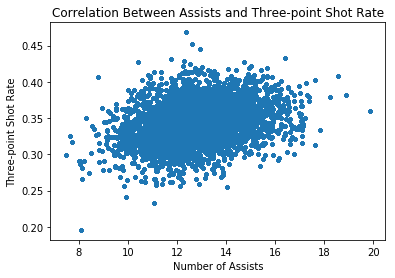

In [85]:
# Plot the number of assists vs. three point rate
fg3 = data.FG3_rate
ast = data.AST
plt.plot(ast, fg3, marker='.', linestyle='none')
plt.xlabel('Number of Assists')
plt.ylabel('Three-point Shot Rate')
plt.title('Correlation Between Assists and Three-point Shot Rate')
plt.savefig('Assists_3pt_plot.png')
plt.show()

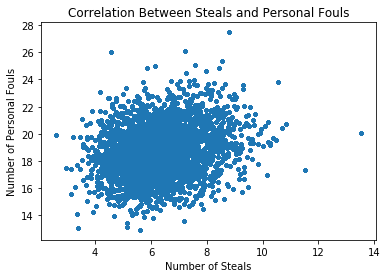

In [86]:
# Plot the number of steal vs. number of personal fouls
stl = data.STL
pf = data.PF
plt.plot(stl, pf, marker='.', linestyle='none')
plt.xlabel('Number of Steals')
plt.ylabel('Number of Personal Fouls')
plt.title('Correlation Between Steals and Personal Fouls')
plt.savefig('Steals_Fouls_plot.png')
plt.show()

### Create boxplots for the field goal rates for each season to see if it has changed over time

In [87]:
fg_rates = []
for s in data.Season.unique():
    sr = list(data[data.Season==s].FG_rate)
    fg_rates.append(sr)

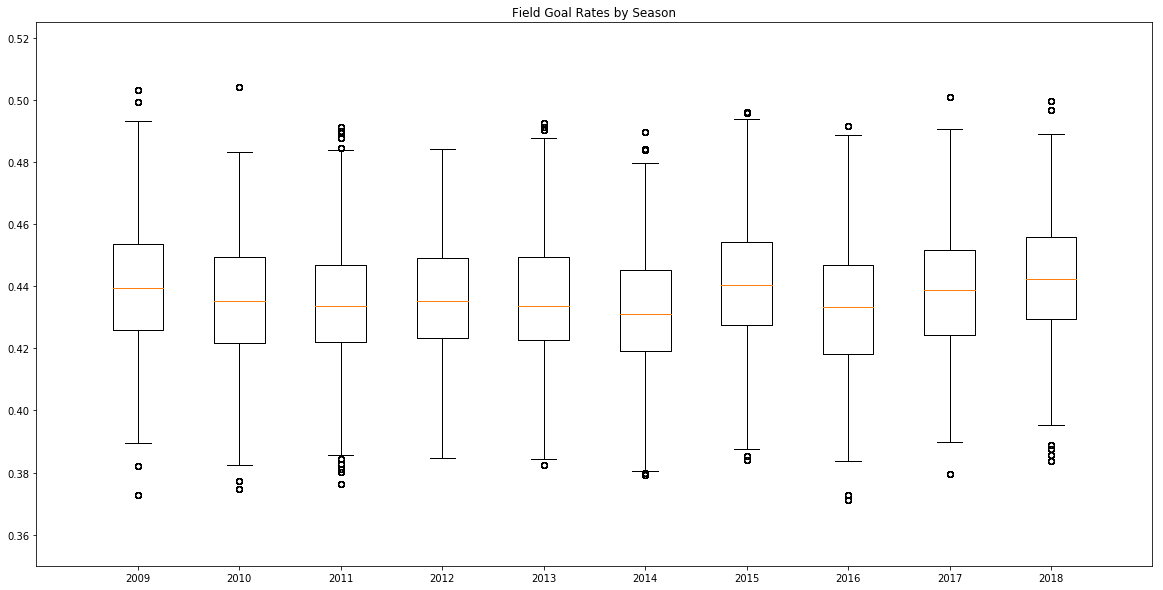

In [88]:
fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title('Field Goal Rates by Season')
_= plt.boxplot(fg_rates, labels = data.Season.unique())
plt.axis([0, 11, 0.35, 0.525])
plt.show()

### There does not appear to be any significant change in the field goal rates over the past 10 years

### Next I will split the data by wins and losses, and compare some of the features

In [134]:
df = pd.read_csv('BasketBallData_2.csv').drop('Unnamed: 0', axis=1)

w_df = df[df.Win==1].drop('Win', axis=1)
n_df = df[df.Win==0].drop('Win', axis=1)

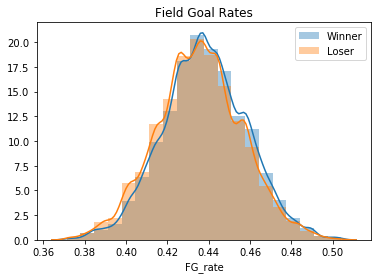

In [135]:
sns.distplot(w_df.FG_rate, bins=20, label='Winner')
sns.distplot(n_df.FG_rate, bins=20, label='Loser')
plt.title('Field Goal Rates')
plt.legend()
plt.show()

### Conduct a hypothesis test for the difference between the features for winners and losers. 

In [136]:
fn.test_for_difference(w_df, n_df, 'two-sided')

The p-value for the difference between  Season is:  0.8638022145217455
The p-value for the difference between  DayNum is:  0.301733929651799
The p-value for the difference between  TeamID is:  1.0940954293605561e-21
The p-value for the difference between  Opp_TeamID is:  2.1730606160780826e-23
The p-value for the difference between  FG_rate is:  1.1690992187359074e-90
The p-value for the difference between  FT_rate is:  2.1576137072197745e-22
The p-value for the difference between  FG3_rate is:  0.040847905191971234
The p-value for the difference between  ORB is:  9.917218927705898e-60
The p-value for the difference between  DRB is:  4.869128034197389e-29
The p-value for the difference between  STL is:  0.010894369429761165
The p-value for the difference between  BLK is:  1.024531353973396e-115
The p-value for the difference between  AST is:  4.265029450411848e-113
The p-value for the difference between  PF is:  2.889326685407225e-09
The p-value for the difference between  Score_Diff i

### We can see that most of the features are significant

In [137]:
# Use lightgbm to fit a model
import lightgbm as lgb
model_data = df.drop(['Season', 'DayNum', 'TeamID', 'Opp_TeamID'], axis=1)

X = model_data.drop('Win', axis=1)
y = model_data.Win
# split into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 10,
        'max_depth': 6,
        'learning_rate': 0.1
                }

model = lgb.train(params, lgb_train, 100)

In [138]:
y_pred = model.predict(X_test)
# Convert the probabilities to binary values
for i in range(0, len(y_pred)-1):
    if y_pred[i]>=0.5:
        y_pred[i]=1
    else:
        y_pred[i]=0
        
y_pred = y_pred.astype(int)
# Compute the accuracy on the test data
score = accuracy_score(y_test, y_pred)
print('The accuracy on the test data is ', 100*round(score, 4), '%')

The accuracy on the test data is  62.44 %


In [139]:
y_pred2 = model.predict(X_train)

# Convert the probabilities to binary values
for i in range(0, len(y_pred2)-1):
    if y_pred2[i]>=0.5:
        y_pred2[i]=1
    else:
        y_pred2[i]=0
        
y_pred2 = y_pred2.astype(int)
# Compute the accuracy on the training data
score_train = accuracy_score(y_train, y_pred2)
print('The accuracy on the training data is ', 100*round(score_train, 4), '%')

The accuracy on the training data is  63.89 %


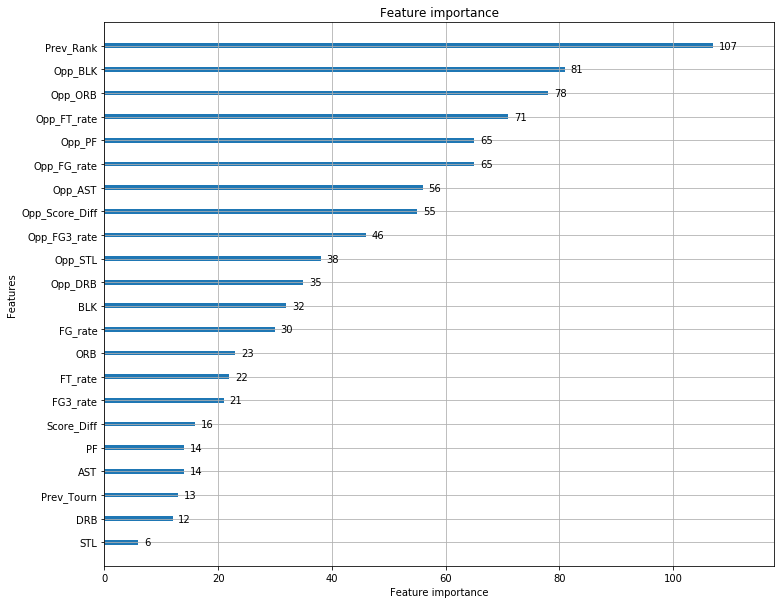

In [140]:
# Plot the feature importanct
_=lgb.plot_importance(model, figsize=(12, 10))
plt.show()